This notebook measures the routing behavior of Smoothie.

In [ ]:
import sys
sys.path.append("..")

import yaml, json
from pathlib import Path
import numpy as np
from collections import Counter

# How many times is each model picked?

We measure how many times Smoothie picks each model in the distribution.

In [150]:
MODEL_GROUPS = {
    "7b": ["mistral-7b", "llama-2-7b", "vicuna-7b", "gemma-7b", "nous-capybara"],
    "3b": ["pythia-2.8b", "gemma-2b", "incite-3b", "dolly-3b"]
}

model_groups = ["3b", "7b"]
dataset_configs = [
    "../dataset_configs/acc_group.yaml",
    "../dataset_configs/rouge2_group.yaml",
]

descriptions = []
stats = []

for model_group in model_groups:
    for config_fpath in dataset_configs:
        config = yaml.load(Path(config_fpath).read_text(), Loader=yaml.FullLoader)
        predictions_path = Path("../smoothie_data/multi_model_results/") / config["dataset"] / model_group
        predictions_path = predictions_path / f"smoothie_sample_dependent_{model_group}_1_test.json"
        outputs = json.loads(predictions_path.read_text())
        models_selected = np.array(MODEL_GROUPS[model_group])[np.array(outputs["smoothie_weights"]).argmax(axis=1)]
        model_counts = Counter(models_selected)
        print("#"*50)
        print(f"{config['dataset']} ({model_group})")
        for model in MODEL_GROUPS[model_group]:
            count = model_counts[model]
            perc = 100*count /len(models_selected)
            print(f"\t{model}: {count} ({perc:.2f})")
        print()
        descriptions.append((model_group, config["dataset"]))
        stats.append(model_counts)
        

##################################################
acc_group (3b)
	pythia-2.8b: 1112 (42.98)
	gemma-2b: 600 (23.19)
	incite-3b: 296 (11.44)
	dolly-3b: 579 (22.38)

##################################################
rouge2_group (3b)
	pythia-2.8b: 1496 (37.40)
	gemma-2b: 893 (22.32)
	incite-3b: 608 (15.20)
	dolly-3b: 1003 (25.07)

##################################################
acc_group (7b)
	mistral-7b: 797 (30.81)
	llama-2-7b: 841 (32.51)
	vicuna-7b: 374 (14.46)
	gemma-7b: 349 (13.49)
	nous-capybara: 226 (8.74)

##################################################
rouge2_group (7b)
	mistral-7b: 815 (20.38)
	llama-2-7b: 525 (13.12)
	vicuna-7b: 1154 (28.85)
	gemma-7b: 671 (16.77)
	nous-capybara: 835 (20.88)



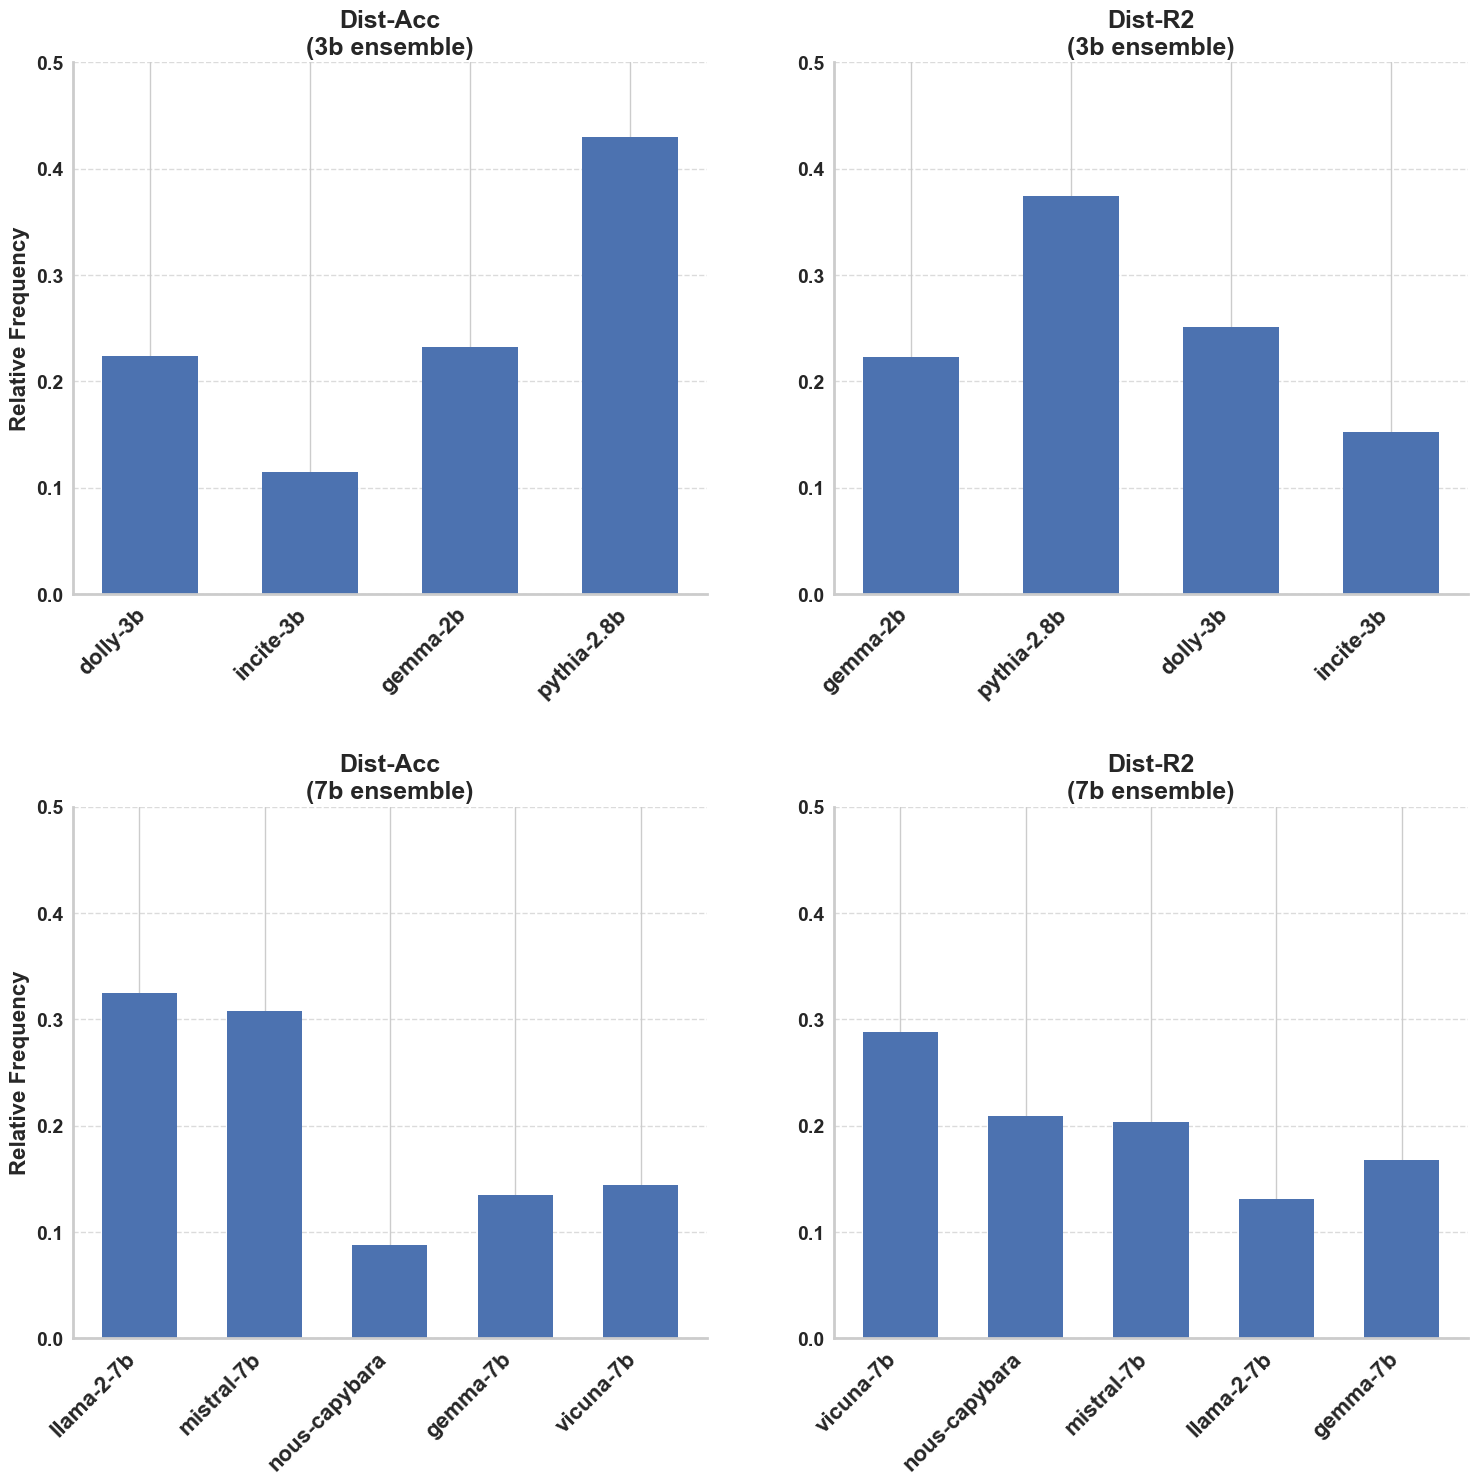

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for a more attractive plot
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

# Increase the default font size and make it bold
plt.rcParams.update({
    'font.size': 14,
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'axes.linewidth': 2  # Make axis lines thicker
})

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Plot each Counter as a bar chart in its own subplot
for i, (counter, (model_group, dataset)) in enumerate(zip(stats, descriptions)):
    ax = axs[i]
    
    # Calculate relative frequencies
    total = sum(counter.values())
    relative_freqs = [count / total for count in counter.values()]
    
    # Create x-axis labels
    x_labels = stats[i].keys()
    
    # Plot bars
    bars = ax.bar(range(len(counter)), relative_freqs, width=0.6)
    
    # Add x-axis labels with larger font size
    ax.set_xticks(range(len(counter)))
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=16)  # Increased font size here
    
    dataset = "Dist-Acc" if dataset == "acc_group" else "Dist-R2"
    ax.set_title(f'{dataset}\n({model_group} ensemble)', fontsize=18, fontweight='bold')
    ax.set_ylim(0, 0.5)  # Set y-axis limit from 0 to 0.5
    
    # Set y-label for the leftmost subplots
    if i % 2 == 0:
        ax.set_ylabel('Relative Frequency', fontsize=16, fontweight='bold')
    else:
        ax.set_ylabel('')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Make visible spines bold
    for spine in ax.spines.values():
        if spine.get_visible():
            spine.set_linewidth(2)
    
    # Add subtle grid lines
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    
    # Increase tick label size for y-axis
    ax.tick_params(axis='y', which='major', labelsize=14, width=2)  # Make tick marks thicker
    
    # Make tick labels bold
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

# Adjust layout and display the plot
plt.tight_layout()

# Adjust the subplot layout to make room for the caption and x-axis labels
plt.subplots_adjust(hspace=0.4, wspace=0.2, bottom=0.1)

plt.savefig("smoothie_routing_dist.png", dpi=300, bbox_inches='tight')

# How does performance compare to the best performing ensemble member?

In [86]:
model_groups = ["3b", "7b"]
dataset_configs = [
    "../dataset_configs/acc_group.yaml",
    "../dataset_configs/rouge2_group.yaml",
]

for model_group in model_groups:
    for config_fpath in dataset_configs:
        config = yaml.load(Path(config_fpath).read_text(), Loader=yaml.FullLoader)
        scores_path = Path("../smoothie_data/multi_model_results/") / config["dataset"] / model_group
        scores_path = scores_path / f"scores.json"
        scores = json.loads(scores_path.read_text())
        best_ensemble = max(scores["ensemble"].values())
        smoothie = scores["smoothie"][f"smoothie_sample_dependent_{model_group}_1"]
        print("#"*50)
        print(f"{config['dataset']} ({model_group})")
        print(f"Best ensemble: {best_ensemble}")
        print(f"Smoothie: {smoothie}")
        print(f"Diff: {smoothie-best_ensemble}")
        print()
        

##################################################
acc_group (3b)
Best ensemble: 0.5226130653266332
Smoothie: 0.592964824120603
Diff: 0.07035175879396982

##################################################
rouge2_group (3b)
Best ensemble: 0.18070747876378482
Smoothie: 0.1974097221532196
Diff: 0.016702243389434795

##################################################
acc_group (7b)
Best ensemble: 0.7321221492075763
Smoothie: 0.7464244298415152
Diff: 0.014302280633938902

##################################################
rouge2_group (7b)
Best ensemble: 0.2644696873142772
Smoothie: 0.27125579127939475
Diff: 0.006786103965117529



# How does Smoothie compare to PairRM on single-task datasets

In [94]:
model_groups = ["7b", "3b"]
dataset_configs = [
    "../dataset_configs/squad.yaml",
    "../dataset_configs/trivia_qa.yaml",
    "../dataset_configs/definition_extraction.yaml",
]

num_where_smoothie_is_better = 0
smoothie_scores = []
pair_rm_scores = []
for model_group in model_groups:
    for config_fpath in dataset_configs:
        config = yaml.load(Path(config_fpath).read_text(), Loader=yaml.FullLoader)
        scores_path = Path("../smoothie_data/multi_model_results/") / config["dataset"] / model_group
        scores_path = scores_path / f"scores.json"
        scores = json.loads(scores_path.read_text())
        scores = scores[list(scores.keys())[0]]
        smoothie = scores["smoothie"][f"smoothie_sample_independent_{model_group}"]
        smoothie_scores.append(smoothie)
        pair_rm = scores[f"pair_rm"]
        pair_rm_scores.append(pair_rm)
        
        if smoothie-pair_rm > 0:
            num_where_smoothie_is_better += 1
print(f"Smoothie is better on {num_where_smoothie_is_better} datasets")
print("Smoothie-PairRM avg:", np.mean(smoothie_scores) - np.mean(pair_rm_scores))
print("Smoothie - PairRM max:", np.max(np.array(smoothie_scores) - np.array(pair_rm_scores)))

Smoothie is better on 1 datasets
Smoothie-PairRM avg: -0.03892674616695058
Smoothie - PairRM max: 0.0732538330494037


In [95]:
model_groups = ["7b", "3b"]
dataset_configs = [
    "../dataset_configs/cnn_dailymail.yaml",
    "../dataset_configs/e2e_nlg.yaml",
    "../dataset_configs/xsum.yaml",
    "../dataset_configs/web_nlg.yaml",
]

num_where_smoothie_is_better = 0
smoothie_scores = []
pair_rm_scores = []
for model_group in model_groups:
    for config_fpath in dataset_configs:
        config = yaml.load(Path(config_fpath).read_text(), Loader=yaml.FullLoader)
        scores_path = Path("../smoothie_data/multi_model_results/") / config["dataset"] / model_group
        scores_path = scores_path / f"scores.json"
        scores = json.loads(scores_path.read_text())
        scores = scores[list(scores.keys())[0]]
        smoothie = scores["smoothie"][f"smoothie_sample_independent_{model_group}"]
        smoothie_scores.append(smoothie)
        pair_rm = scores[f"pair_rm"]
        pair_rm_scores.append(pair_rm)
        
        if smoothie-pair_rm > 0:
            num_where_smoothie_is_better += 1
print(f"Smoothie is better on {num_where_smoothie_is_better} datasets")
print("Smoothie-PairRM avg:", np.mean(smoothie_scores) - np.mean(pair_rm_scores))
print("Smoothie - PairRM max:", np.max(np.array(smoothie_scores) - np.array(pair_rm_scores)))

Smoothie is better on 5 datasets
Smoothie-PairRM avg: 0.0013605898339007494
Smoothie - PairRM max: 0.01293970335229283


# How does Smoothie compare to PairRM on multi-task datasets

In [9]:
import sys
sys.path.append("..")

import yaml
from pathlib import Path
import json
import numpy as np
from collections import Counter

model_groups = ["3b", "7b"]
dataset_configs = [
    "../dataset_configs/acc_group.yaml",
    "../dataset_configs/rouge2_group.yaml",
]

num_where_smoothie_is_better = 0

for model_group in model_groups:
    for config_fpath in dataset_configs:
        config = yaml.load(Path(config_fpath).read_text(), Loader=yaml.FullLoader)
        scores_path = Path("../smoothie_data/multi_model_results/") / config["dataset"] / model_group
        scores_path = scores_path / f"scores.json"
        scores = json.loads(scores_path.read_text())
        smoothie = scores["smoothie"][f"smoothie_sample_dependent_{model_group}_1"]
        pair_rm = scores[f"pair_rm"]
        print("#"*50)
        print(f"{config['dataset']} ({model_group})")
        print(f"PairRM: {pair_rm}")
        print(f"Smoothie: {smoothie}")
        print(f"Diff: {smoothie-pair_rm}")
        if smoothie-pair_rm > 0:
            num_where_smoothie_is_better += 1
        print()
print(f"Smoothie is better on {num_where_smoothie_is_better} datasets")

##################################################
acc_group (3b)
PairRM: 0.5921917278701199
Smoothie: 0.592964824120603
Diff: 0.0007730962504831629

##################################################
rouge2_group (3b)
PairRM: 0.20357519755854123
Smoothie: 0.1974097221532196
Diff: -0.006165475405321613

##################################################
acc_group (7b)
PairRM: 0.714340935446463
Smoothie: 0.7464244298415152
Diff: 0.0320834943950522

##################################################
rouge2_group (7b)
PairRM: 0.2594600699630303
Smoothie: 0.27125579127939475
Diff: 0.011795721316364471

Smoothie is better on 3 datasets


In [91]:
(0.011795721316364471 -0.006165475405321613)/2

0.002815122955521429

# Smoothie Sample Rank Comparison

In [209]:
def rank_scores(scores_dict):
    n = len(next(iter(scores_dict.values())))  # Get length of score arrays
    result = [{} for _ in range(n)]
    
    for i in range(n):
        # Extract ith scores from each model
        ith_scores = {model: scores[i] for model, scores in scores_dict.items()}
        
        # Sort models by their scores in descending order
        sorted_models = sorted(ith_scores.items(), key=lambda x: x[1], reverse=True)
        # Assign ranks
        current_rank = 1
        n_on_current_rank = 0
        current_score = sorted_models[0][1]
        for model, score in sorted_models:
            if score == current_score:
                result[i][score] = current_rank
                n_on_current_rank += 1
            else:
                current_rank += n_on_current_rank
                result[i][score] = current_rank
                current_score = score    
                n_on_current_rank = 1
    return result


def compute_avg_rank(scores, ranks_dicts):
    ranks = []
    for idx in range(len(scores)):
        ranks.append(ranks_dicts[idx][scores[idx]])
    return np.mean(ranks)

In [210]:
rank_scores({
        'Model A': [0.9, 0.8],
        'Model B': [0.8, 0.9],
        'Model C': [0.7, 0.7]
    })

[{0.9: 1, 0.8: 2, 0.7: 3}, {0.9: 1, 0.8: 2, 0.7: 3}]

In [211]:
import sys
sys.path.append("..")

import yaml
from pathlib import Path
import json
import numpy as np
from collections import Counter

model_groups = ["3b", "7b"]
config_fpath = "../dataset_configs/rouge2_group.yaml"
for model_group in model_groups:
    config = yaml.load(Path(config_fpath).read_text(), Loader=yaml.FullLoader)
    scores_path = Path("../smoothie_data/multi_model_results/") / config["dataset"] / model_group
    scores_path = scores_path / f"sample_scores.json"
    sample_scores = json.loads(scores_path.read_text())
    score_to_rank = rank_scores(sample_scores["ensemble"])

    # Compute median/max of ensemble
    ensemble_scores = np.array([v for v in sample_scores["ensemble"].values()])
    best_scores = ensemble_scores.max(axis=0)
    median_scores = np.median(ensemble_scores, axis=0)

    # Compute how often Smoothie beats/matches median/max
    smoothie_scores = np.array(sample_scores["smoothie"][f"smoothie_sample_dependent_{model_group}_1"])

    print("#"*50)
    print(f"{config['dataset']} ({model_group})")
    print("Smoothie matches best:", (smoothie_scores >= best_scores).mean())
    print("Smoothie matches/beats median:", (smoothie_scores >= median_scores).mean())
    print()


config_fpath = "../dataset_configs/acc_group.yaml"
for model_group in model_groups:
    config = yaml.load(Path(config_fpath).read_text(), Loader=yaml.FullLoader)
    scores_path = Path("../smoothie_data/multi_model_results/") / config["dataset"] / model_group
    scores_path = scores_path / f"sample_scores.json"
    sample_scores = json.loads(scores_path.read_text())
    score_to_rank = rank_scores(sample_scores["ensemble"])

    # Compute median/max of ensemble
    ensemble_scores = np.array([v for v in sample_scores["ensemble"].values()])
    best_scores = ensemble_scores.max(axis=0)
    majority_scores = np.round(np.mean(ensemble_scores, axis=0))

    # Compute how often Smoothie beats/matches median/max
    smoothie_scores = np.array(sample_scores["smoothie"][f"smoothie_sample_dependent_{model_group}_1"])

    print("#"*50)
    print(f"{config['dataset']} ({model_group})")
    print("Smoothie matches best:", (smoothie_scores >= best_scores).mean())
    print("Smoothie matches/beats median:", (smoothie_scores >= majority_scores).mean())
    print()

##################################################
rouge2_group (3b)
Smoothie matches best: 0.3615
Smoothie matches/beats median: 0.727

##################################################
rouge2_group (7b)
Smoothie matches best: 0.2735
Smoothie matches/beats median: 0.785

##################################################
acc_group (3b)
Smoothie matches best: 0.85195206803247
Smoothie matches/beats median: 0.9992269037495168

##################################################
acc_group (7b)
Smoothie matches best: 0.8894472361809045
Smoothie matches/beats median: 0.9872439118670274



# Visualize rank distribution

In [212]:
model_groups = ["3b", "7b"]
config_fpaths = [
    "../dataset_configs/acc_group.yaml",
    "../dataset_configs/rouge2_group.yaml",
]
descriptions = []
stats = []
for model_group in model_groups:
    for config_fpath in config_fpaths:
        config = yaml.load(Path(config_fpath).read_text(), Loader=yaml.FullLoader)
        scores_path = Path("../smoothie_data/multi_model_results/") / config["dataset"] / model_group
        scores_path = scores_path / f"sample_scores.json"
        sample_scores = json.loads(scores_path.read_text())
        score_to_rank = rank_scores(sample_scores["ensemble"])
        smoothie_scores = np.array(sample_scores["smoothie"][f"smoothie_sample_dependent_{model_group}_1"])
        ranks = [score_to_rank[idx][smoothie_scores[idx]] for idx in range(len(smoothie_scores))]

        descriptions.append((model_group, config["dataset"]))
        stats.append(ranks)

In [214]:
descriptions

[('3b', 'acc_group'),
 ('3b', 'rouge2_group'),
 ('7b', 'acc_group'),
 ('7b', 'rouge2_group')]

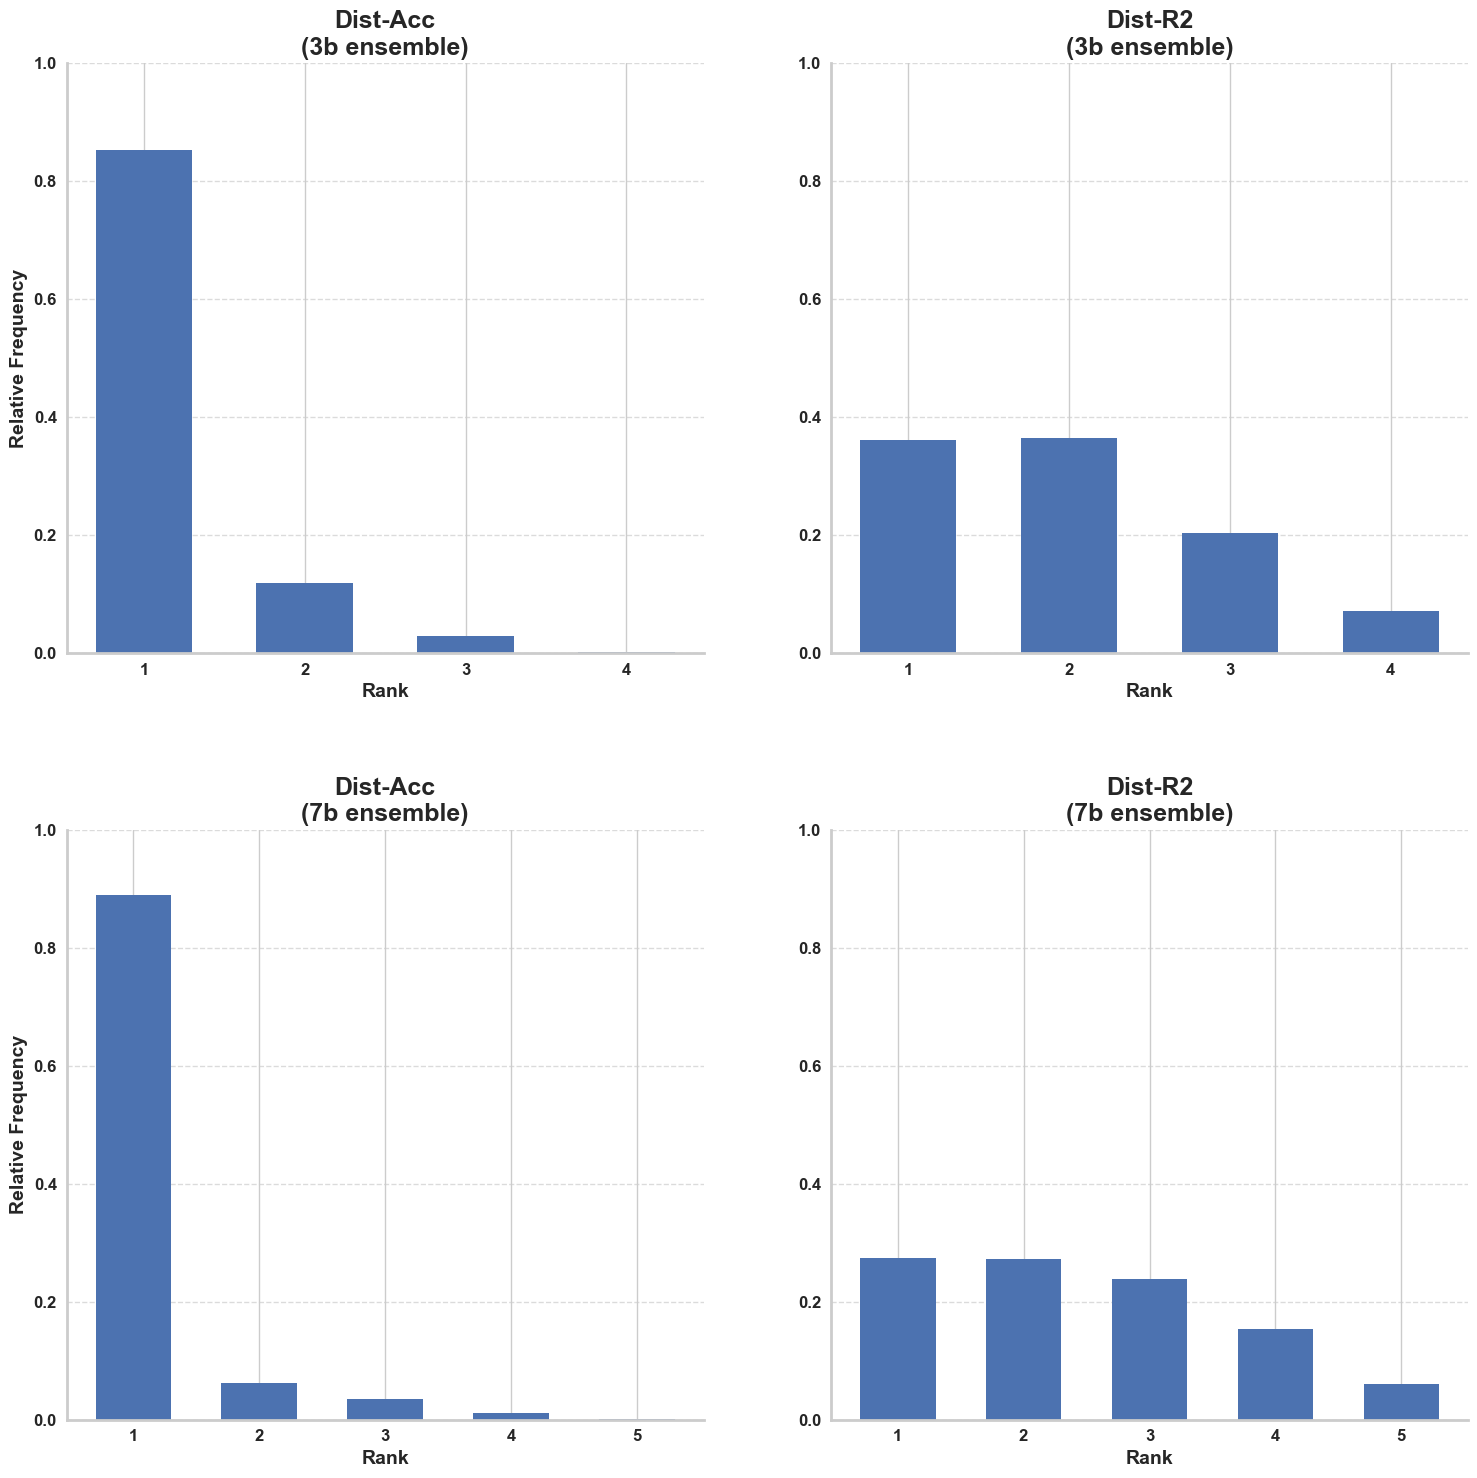

In [215]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Assuming stats is your list of 4 lists
# stats = [list1, list2, list3, list4]

# Set the style for a more attractive plot
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

# Increase the default font size and make it bold
plt.rcParams.update({
    'font.size': 14,
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'axes.linewidth': 2  # Make axis lines thicker
})

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Plot each list's rank distribution in its own subplot
for i, rank_list in enumerate(stats):
    ax = axs[i]
    
    # Count the occurrences of each rank
    rank_counts = Counter(rank_list)
    
    # Ensure all ranks from 1 to max rank are represented
    max_rank = max(rank_list)
    for rank in range(1, max_rank + 1):
        if rank not in rank_counts:
            rank_counts[rank] = 0
    
    # Sort the ranks
    sorted_ranks = sorted(rank_counts.items())
    ranks, counts = zip(*sorted_ranks)
    
    # Calculate relative frequencies
    total = sum(counts)
    relative_freqs = [count / total for count in counts]
    
    # Plot bars
    bars = ax.bar(ranks, relative_freqs, width=0.6)
    
    # Set title and labels
    model_group, dataset = descriptions[i]
    dataset = "Dist-Acc" if dataset == "acc_group" else "Dist-R2"
    ax.set_title(f'{dataset}\n({model_group} ensemble)', fontsize=18, fontweight='bold')
    ax.set_xlabel('Rank', fontsize=14, fontweight='bold')
    if i % 2 == 0:  # Only set y-label for the leftmost plots
        ax.set_ylabel('Relative Frequency', fontsize=14, fontweight='bold')
    
    # Set x-ticks to be integer ranks
    ax.set_xticks(ranks)
    ax.set_xticklabels(ranks, fontsize=12, fontweight='bold')
    
    # Set y-axis limit from 0 to 1
    ax.set_ylim(0, 1)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Make visible spines bold
    for spine in ax.spines.values():
        if spine.get_visible():
            spine.set_linewidth(2)
    
    # Add subtle grid lines
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    
    # Increase tick label size
    ax.tick_params(axis='both', which='major', labelsize=12, width=2)
    
    # Make tick labels bold
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

# Adjust layout and display the plot
plt.tight_layout()

# Adjust the subplot layout
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.savefig("rank_distribution.png", dpi=300, bbox_inches='tight')

# Smoothie train-time on individual task datasets

In [67]:
import sys
sys.path.append("..")

import yaml
from pathlib import Path
import json
import numpy as np
from collections import Counter

MODEL_GROUPS = {
    "7b": ["mistral-7b", "llama-2-7b", "vicuna-7b", "gemma-7b", "nous-capybara"],
    "3b": ["pythia-2.8b", "gemma-2b", "incite-3b", "dolly-3b"]
}


model_groups = ["7b", "3b"]
dataset_configs = [
    "../dataset_configs/squad.yaml",
    "../dataset_configs/trivia_qa.yaml",
    "../dataset_configs/definition_extraction.yaml",
    "../dataset_configs/cnn_dailymail.yaml",
    "../dataset_configs/e2e_nlg.yaml",
    "../dataset_configs/xsum.yaml",
    "../dataset_configs/web_nlg.yaml",
]

smoothie_identifies_best = 0

for model_group in model_groups:
    for config_fpath in dataset_configs:
        config = yaml.load(Path(config_fpath).read_text(), Loader=yaml.FullLoader)
        scores_path = Path("../smoothie_data/multi_model_results/") / config["dataset"] / model_group
        scores_path = scores_path / f"scores.json"
        scores = json.loads(scores_path.read_text())
        scores = scores[list(scores.keys())[0]]
        smoothie = scores["smoothie"][f"smoothie_tt_sample_independent_{model_group}"]
        best_ensemble = max(scores["ensemble"].values())
        if smoothie == best_ensemble:
            smoothie_identifies_best += 1
        random_score = scores[f'pick_random_{model_group}']

        print("#"*50)
        print(f"{config['dataset']} ({model_group})")
        print(f"Random: {random_score}")
        print(f"Smoothie: {smoothie}")
        print(f"Diff: {smoothie-random_score}")
        print()
    
print(f"Smoothie identifies best model on {smoothie_identifies_best} datasets")

##################################################
squad (7b)
Random: 0.6819
Smoothie: 0.762
Diff: 0.08010000000000006

##################################################
trivia_qa (7b)
Random: 0.5908999999999999
Smoothie: 0.683
Diff: 0.09210000000000018

##################################################
definition_extraction (7b)
Random: 0.5834752981260648
Smoothie: 0.7086882453151618
Diff: 0.12521294718909703

##################################################
cnn_dailymail (7b)
Random: 0.13643858575206624
Smoothie: 0.1454820006471118
Diff: 0.009043414895045565

##################################################
e2e_nlg (7b)
Random: 0.35200865069811876
Smoothie: 0.36921502286838076
Diff: 0.017206372170261997

##################################################
xsum (7b)
Random: 0.06818523209183844
Smoothie: 0.08351874642974755
Diff: 0.01533351433790911

##################################################
web_nlg (7b)
Random: 0.4413745378442406
Smoothie: 0.45887978663255774
Diff: 0.017

# Smoothie train-time on multi-task datasets

In [108]:
model_groups = ["7b", "3b"]
config_fpath = "../dataset_configs/acc_group.yaml"
random_scores = []
smoothie_scores = []
for model_group in model_groups:
    config = yaml.load(Path(config_fpath).read_text(), Loader=yaml.FullLoader)
    scores_path = Path("../smoothie_data/multi_model_results/") / config["dataset"] / model_group
    scores_path = scores_path / f"scores.json"
    scores = json.loads(scores_path.read_text())
    smoothie = scores["smoothie"][f"smoothie_tt_sample_dependent_{model_group}_20"]
    random = scores[f"pick_random_{model_group}"]
    lo = scores[f"labeled_oracle_{model_group}"]

    smoothie_scores.append(smoothie)
    random_scores.append(random)

print("Avg Smoothie-Random:", np.mean(np.array(smoothie_scores) - np.array(random_scores)))

Avg Smoothie-Random: 0.03676072671047545


In [109]:
model_groups = ["7b", "3b"]
config_fpath = "../dataset_configs/rouge2_group.yaml"
random_scores = []
smoothie_scores = []
for model_group in model_groups:
    config = yaml.load(Path(config_fpath).read_text(), Loader=yaml.FullLoader)
    scores_path = Path("../smoothie_data/multi_model_results/") / config["dataset"] / model_group
    scores_path = scores_path / f"scores.json"
    scores = json.loads(scores_path.read_text())
    smoothie = scores["smoothie"][f"smoothie_tt_sample_dependent_{model_group}_20"]
    random = scores[f"pick_random_{model_group}"]
    lo = scores[f"labeled_oracle_{model_group}"]

    smoothie_scores.append(smoothie)
    random_scores.append(random)

print("Avg Smoothie-Random:", np.mean(np.array(smoothie_scores) - np.array(random_scores)))

Avg Smoothie-Random: 0.015904827648202627
